In [1]:
import sys
import cv2
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FPS = 20
# DELAY = int(1.0 / FPS * 1000)
FOCAL = 910  # pixels

In [3]:
# List files with videos and velocities
videos = sorted(glob.glob('labeled/*.hevc'))
vels = sorted(glob.glob('labeled/*.txt'))

In [4]:
# Read first video and velocities
curr_vel, curr_vid = vels[0], videos[0]

In [5]:
# Load all images from capture
imgs = []
cap = cv2.VideoCapture(curr_vid)
dir_x_y = np.loadtxt(curr_vel)
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        imgs.append(frame)
    else:
        print('All images read')
        break
imgs = np.array(imgs)
cap.release()

All images read


In [6]:
dir_x_y.shape

(1200, 2)

In [7]:
imgs.shape

(1200, 874, 1164, 3)

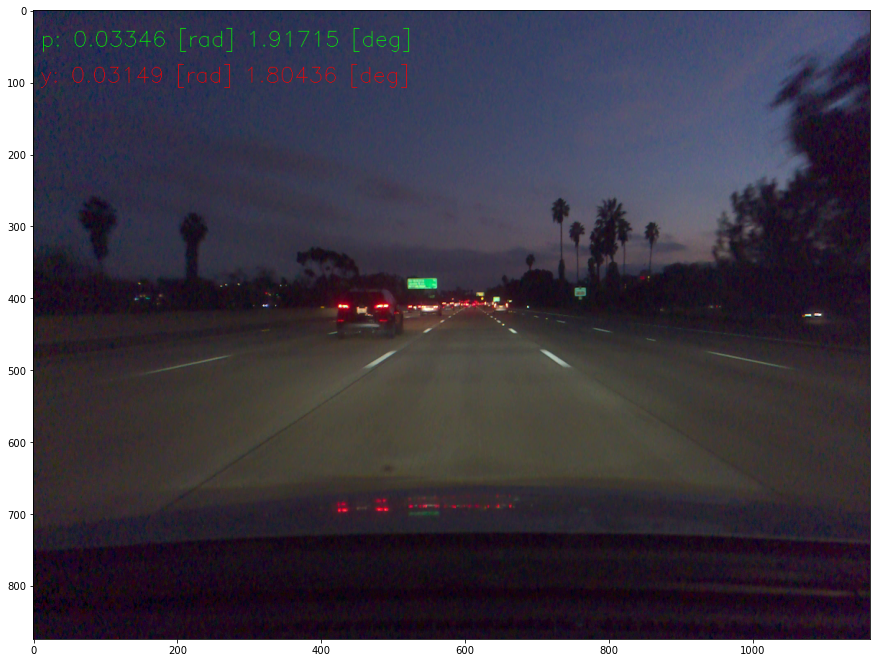

In [8]:
# Visualize single frame
frame_no = 0
frame = imgs[frame_no].copy()
pitch = dir_x_y[frame_no][0]
pitch_deg = np.rad2deg(pitch)
yaw = dir_x_y[frame_no][1]
yaw_deg = np.rad2deg(yaw)
cv2.putText(img=frame,
            text=f'p: {pitch:.5f} [rad] {pitch_deg:.5f} [deg]',
            org=(10, 50),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0))
cv2.putText(img=frame,
            text=f'y: {yaw:.5f} [rad] {yaw_deg:.5f} [deg]',
            org=(10, 100),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(255, 0, 0))
plt.figure(figsize=(15, 15))
plt.imshow(frame)

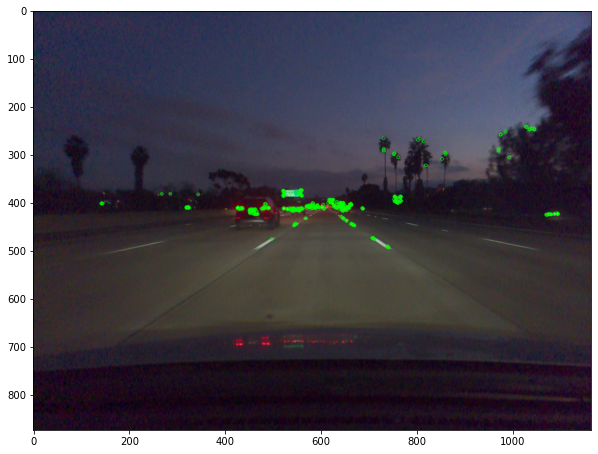

In [10]:
# Visualize features for single frame
orb = cv2.ORB_create()
kp0 = orb.detect(imgs[0])
kp0, desc0 = orb.compute(imgs[0], kp0)
f_drawn0 = cv2.drawKeypoints(imgs[0], kp0, None, color=(0, 255, 0), flags=0)
plt.figure(figsize=(10, 10))
plt.imshow(f_drawn0)

In [12]:
matcher = cv2.BFMatcher_create(normType=cv2.NORM_HAMMING)

# for i in range(1, len(imgs)):
#     kp0 = orb.detect(imgs[i - 1])
#     kp0, desc0 = orb.compute(imgs[i - 1], kp0)
#     kp1 = orb.detect(imgs[i])
#     kp1, desc1 = orb.compute(imgs[i], kp1)
#     matches = matcher.match(desc0, desc1)
#     matches = sorted(matches, key = lambda x : x.distance)
    
#     matched_imgs = cv2.drawMatches(imgs[i - 1], kp0, imgs[i], kp1, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#     plt.figure(figsize=(25, 15))
#     plt.imshow(matched_imgs)
    
#     if i == 2:
#         break

162
5
158
1


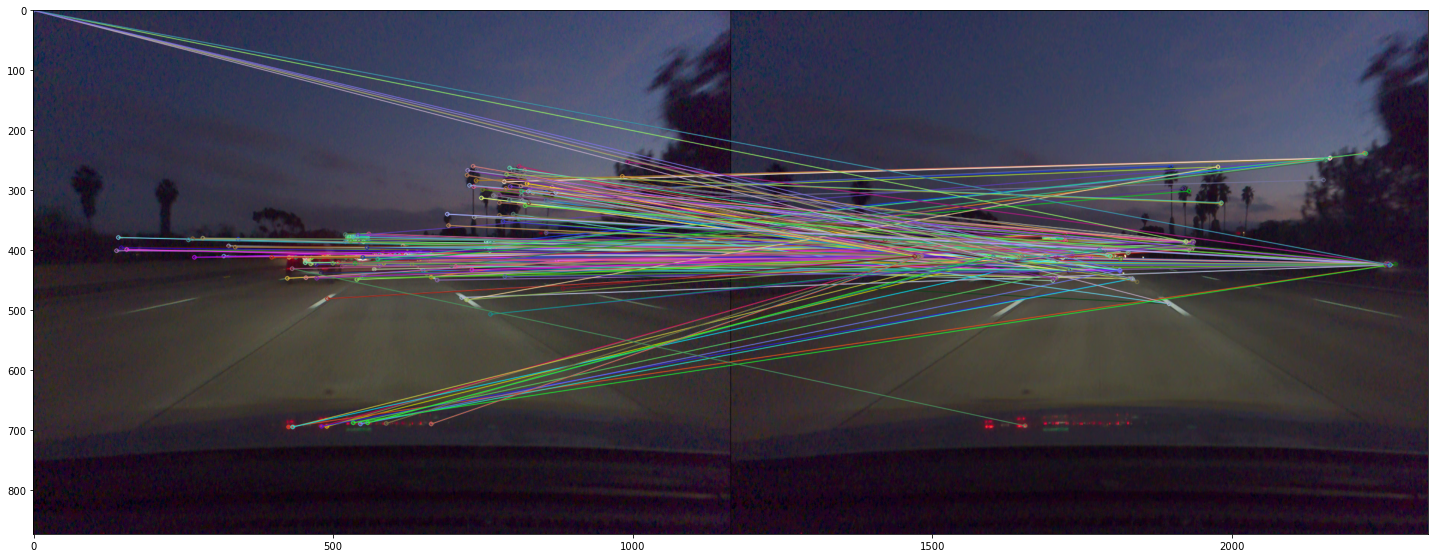

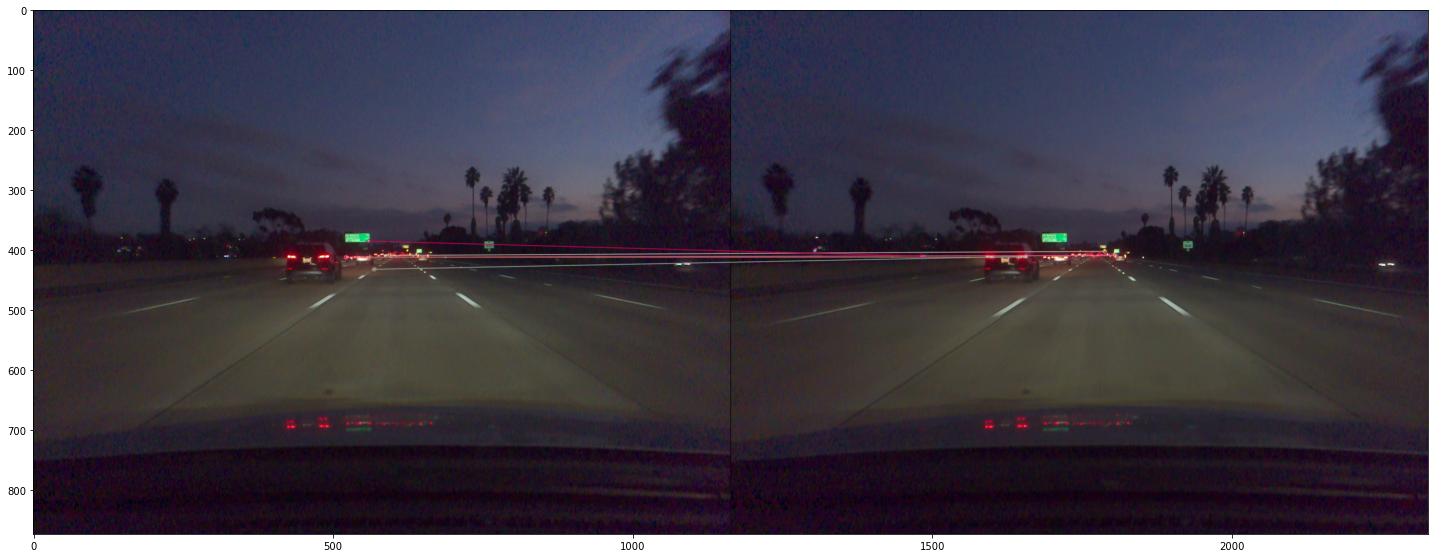

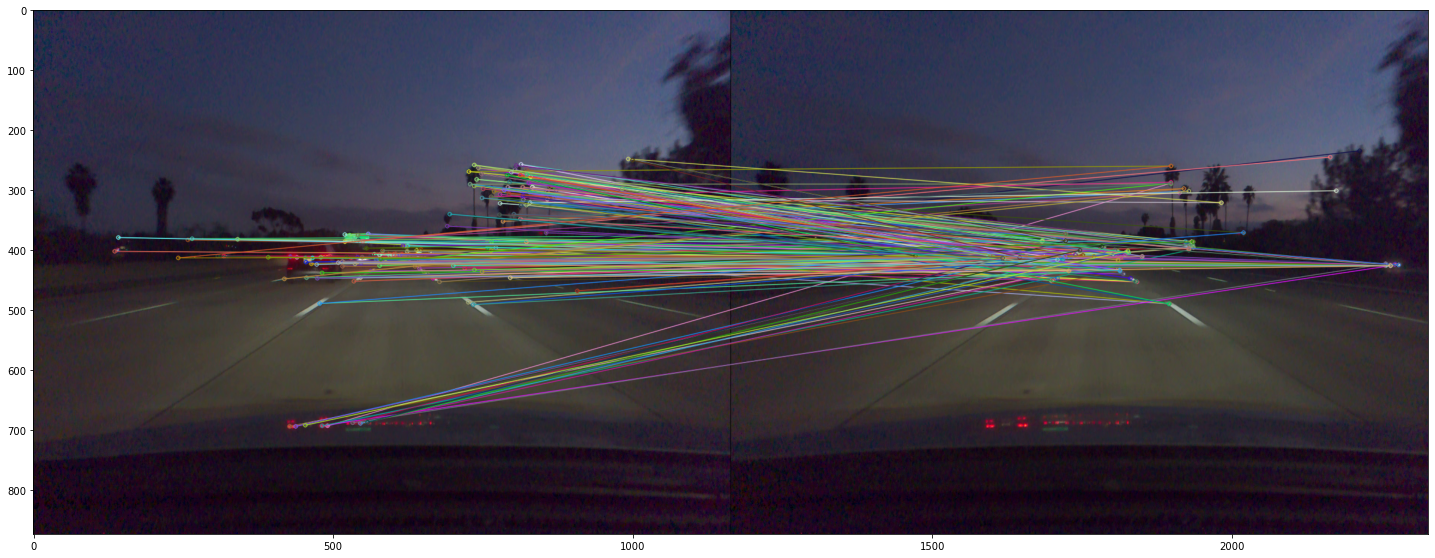

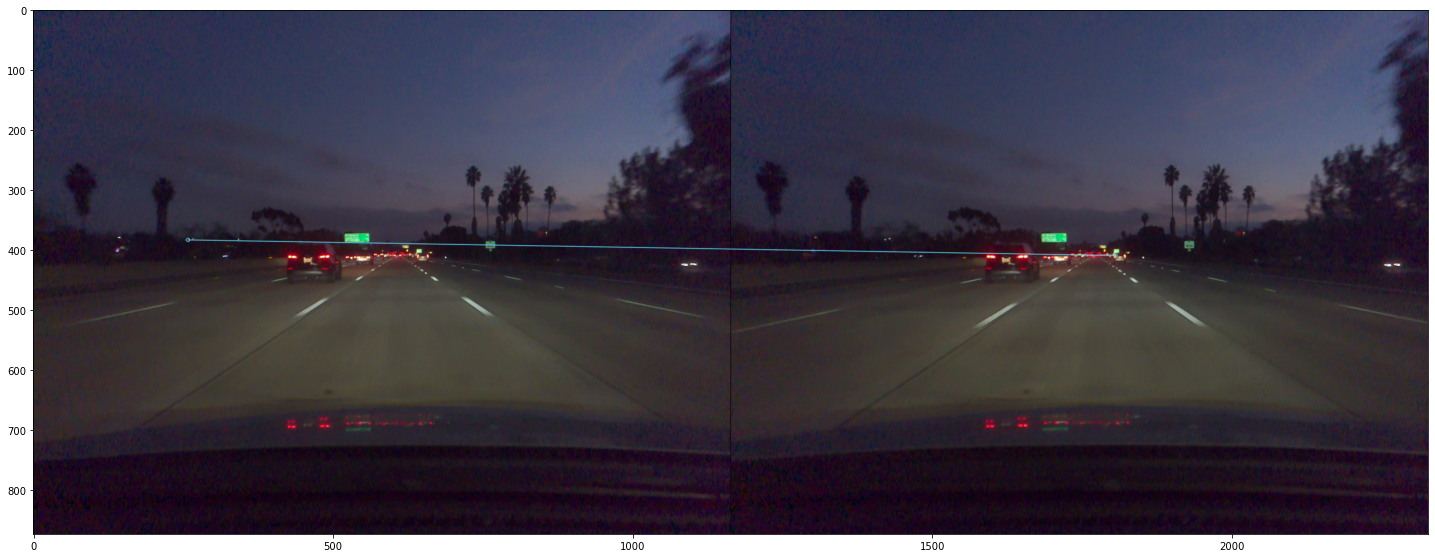

In [23]:
# Try using good features to track function
matcher = cv2.BFMatcher_create(normType=cv2.NORM_HAMMING)

for i in range(1, len(imgs)):
    # Previous frame
    pts = cv2.goodFeaturesToTrack(cv2.cvtColor(imgs[i - 1], cv2.COLOR_BGR2GRAY), maxCorners=3000, qualityLevel=0.01, minDistance=7) 
    pts = np.squeeze(pts)
    kp0 = cv2.KeyPoint_convert(pts)
    kp0, desc0 = orb.compute(imgs[i - 1], kp0)

    # Current frame
    pts = cv2.goodFeaturesToTrack(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY), maxCorners=3000, qualityLevel=0.01, minDistance=7) 
    pts = np.squeeze(pts)
    kp0 = cv2.KeyPoint_convert(pts)
    kp1, desc1 = orb.compute(imgs[i], kp1)

    # Match keypoints
    matches = matcher.knnMatch(desc0, desc1, k=2)
    print(len(matches))
    
    matched_imgs = cv2.drawMatchesKnn(imgs[i - 1], kp0, 
                                      imgs[i], kp1, 
                                      matches, None, 
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(25, 15))
    plt.imshow(matched_imgs)
    
    # Filter matches using the Lowe's ratio test
    ratio_thresh = 0.75
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    print(len(good_matches))
    
    matched_imgs = cv2.drawMatches(imgs[i - 1], kp0, 
                                      imgs[i], kp1, 
                                      good_matches, None, 
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(25, 15))
    plt.imshow(matched_imgs)
    
    if i == 2:
        break
        

In [16]:
matches[:5]

((<DMatch 0x7f6df17e79b0>, <DMatch 0x7f6da43dc390>),
 (<DMatch 0x7f6da5402970>, <DMatch 0x7f6da54028b0>),
 (<DMatch 0x7f6da5402190>, <DMatch 0x7f6da54029b0>),
 (<DMatch 0x7f6da5402bd0>, <DMatch 0x7f6da5402bb0>),
 (<DMatch 0x7f6da5402030>, <DMatch 0x7f6da5402ad0>))

In [52]:
dir(matches[0])

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'distance',
 'imgIdx',
 'queryIdx',
 'trainIdx']

In [56]:
matches[0].trainIdx

122